In [2]:
import io
import telegram
import numpy as np
import pandas as pd
import datetime as dt
import pandahouse as ph
import matplotlib.pyplot as plt
import seaborn as sns


from airflow.decorators import dag, task
from airflow.operators.python import get_current_context

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database':'simulator_20230120',
    'user':'student',
    'password':'dpo_python_2020'
}


my_token='5879848815:AAEjsIFCIOeCVxF18znOsh-PvkuIVqpyeHU'
chat_id = 534065724
bot = telegram.Bot(token=my_token)


In [3]:
LAST_15MIN_QUERY = """
SELECT
    count(distinct user_id) AS active_users,
    countIf(user_id,action='like') as likes,
    countIf(user_id,action='view') as views,
    likes/views as ctr
FROM
  {db}.feed_actions
WHERE
  time >= now() - 60 * 30
GROUP BY
  toDateTime(intDiv(toUInt32(toDateTime(time)), 900) * 900)
ORDER BY
  toDateTime(intDiv(toUInt32(toDateTime(time)), 900) * 900) DESC
LIMIT
  1 offset 1
"""

LAST_15MIN_MSG_QUERY = """
SELECT
    count(distinct user_id) AS active_users,
    count(*) as msgs
FROM
  {db}.message_actions
WHERE
  time >= now() - 60 * 60*30
GROUP BY
  toDateTime(intDiv(toUInt32(toDateTime(time)), 900) * 900)
ORDER BY
  toDateTime(intDiv(toUInt32(toDateTime(time)), 900) * 900) DESC
"""

In [4]:
# calculate standard stat metrics over five lasts 15-min intervals
# and compatre it with the last full 15min interval
LAST_5INTERVALS_QUERY = """WHERE time >= now() - 60*60*1.5"""

# calculate standard stat metrics over same time from yesterday
YESTERDAY_5INTERVAlS_QUERY ="""
WHERE time < now() - 60*60*24*1
and time >= now() - 60*60*24*1 -60*60*1.5
"""
# calculate standard stat metrics over same time from yone wee ago
WEEK_AGOU_5INTERVAlS_QUERY = """
WHERE time < now() - 60*60*24*7
and time >= now() - 60*60*24*7 -60*60*1.5
"""

# generate conf interval query
CONF_INTERVAL_QUERY_PREF  = """
with tmp_t as (
SELECT toDateTime(intDiv(toUInt32(toDateTime(time)), 900)*900) AS __timestamp,
       count(distinct user_id) AS active_users,
       countIf(user_id,action='like') as likes,
       countIf(user_id,action='view') as views,
       likes/views as ctr
FROM {db}.feed_actions
"""

CONF_INTERVAL_QUERY_MSG_PREF = """
with tmp_t as (
SELECT count(distinct user_id) AS active_users,
       count(*) as msgs,
       toDateTime(intDiv(toUInt32(toDateTime(time)), 900)*900) as __timestamp
FROM
  {db}.message_actions

"""


CONF_INTERVAL_QUERY_SUFF = """
GROUP BY __timestamp
ORDER BY __timestamp DESC
LIMIT 6 offset 1
)

"""
#
CONF_INTERVAL_QUERY_TODAY =  CONF_INTERVAL_QUERY_PREF + LAST_5INTERVALS_QUERY +CONF_INTERVAL_QUERY_SUFF
CONF_INTERVAL_QUERY2_YESTERDAY =  CONF_INTERVAL_QUERY_PREF + YESTERDAY_5INTERVAlS_QUERY +CONF_INTERVAL_QUERY_SUFF
CONF_INTERVAL_QUERY3_WEEK =  CONF_INTERVAL_QUERY_PREF + WEEK_AGOU_5INTERVAlS_QUERY +CONF_INTERVAL_QUERY_SUFF
#
CONF_INTERVAL_QUERY_MSG_TODAY =  CONF_INTERVAL_QUERY_MSG_PREF + LAST_5INTERVALS_QUERY +CONF_INTERVAL_QUERY_SUFF
CONF_INTERVAL_QUERY2_MSG_YESTERDAY =  CONF_INTERVAL_QUERY_MSG_PREF + YESTERDAY_5INTERVAlS_QUERY +CONF_INTERVAL_QUERY_SUFF
CONF_INTERVAL_QUERY3_MSG_WEEK =  CONF_INTERVAL_QUERY_MSG_PREF + WEEK_AGOU_5INTERVAlS_QUERY +CONF_INTERVAL_QUERY_SUFF


# function get time interval in query and calculates the 
# standard stat metrics for feed
def compare_metrics_from_conf_interval(time_interval_query ):
    template_query = """select
      quantile(0.75)(active_users) as "usr_q75",
      quantile(0.25)(active_users) as "usr_q25",
      (usr_q75 - usr_q25) as "usr_iqr",
      avg(likes) as "likes_avg",
      avg(views) as "views_avg",
      avg(ctr) as "ctr_avg",
      stddevSampStable(likes) as "likes_std",
      stddevSampStable(views) as "views_std",
      stddevSampStable(ctr) as "ctr_std"
    from
      tmp_t"""

    test = time_interval_query + template_query
    return ph.read_clickhouse(test, connection=connection)

def compare_metrics_msg_from_conf_interval(time_interval_query ):
    template_query = """select
      quantile(0.75)(active_users) as "usr_q75",
      quantile(0.25)(active_users) as "usr_q25",
      (usr_q75 - usr_q25) as usr_iqr,
      quantile(0.75)(msgs) as "msg_q75",
      quantile(0.25)(msgs) as "msg_q25",
      (msg_q75 - msg_q25) as "msg_iqr"
    from
      tmp_t"""

    test = time_interval_query + template_query
    return ph.read_clickhouse(test, connection=connection)

#compare_metrics_from_conf_interval(CONF_INTERVAL_QUERY_TODAY)

In [5]:
# calculate avg and stdv over five 15-min intervals for feed
# and compatre it with the last full 15min interval
def get_feed_alert(last15min_df, conf_df,group_str):
    active_users = last15min_df['active_users'][0]
    likes = last15min_df['likes'][0]
    views = last15min_df['views'][0]
    ctr = last15min_df['ctr'][0]

    usr_iqr=conf_df['usr_iqr'][0] 
    usr_q75=conf_df['usr_q75'][0] 
    usr_q25=conf_df['usr_q25'][0] 
    likes_avg =conf_df['likes_avg'][0] 
    views_avg =conf_df['views_avg'][0] 
    ctr_avg =conf_df['ctr_avg'][0] 
    likes_std =conf_df['likes_std'][0] 
    views_std =conf_df['views_std'][0] 
    ctr_std =conf_df['ctr_std'][0] 
    
    alarm = False
    
    
    txt = """
Feed Метрика {metric_name} в сравнение {group}. 
Текущее значение {current_x}. Отклонение от обычного поведения между {x}.
риалтайм дашборд http://superset.lab.karpov.courses/r/3036
"""
    
    if not(usr_q25-1.5*usr_iqr <= active_users <= usr_q75+1.5*usr_iqr):
        txt_send=txt.format(metric_name = "активных пользователей",group=group_str,current_x=active_users,x="[" + str(usr_q25-1.5*usr_iqr) + ".."+ str(usr_q75+1.5*usr_iqr) + "]")
        #bot.sendMessage(chat_id=chat_id, text=f"Падение уровня относительно пеоследнего 1.5 часа")
        print(txt_send)
    
    if not(likes_avg-3*likes_std <= likes <= likes_avg+3*likes_std):
        txt_send=txt.format(metric_name = "likes",group=group_str,current_x=likes,x="[" + str(likes_avg-3*likes_std) + ".."+ str(likes_avg+3*likes_std) + "]")
        #bot.sendMessage(chat_id=chat_id, text=f"Падение уровня относительно пеоследнего 1.5 часа")
        print(txt_send)
    
    if not(views_avg-3*likes_std <= views <= views_avg+3*likes_std):
        txt_send=txt.format(metric_name = "views",group=group_str,current_x=views,x="[" + str(views_avg-3*likes_std) + ".."+ str(views_avg+3*likes_std) + "]")
        print(txt_send)
        #bot.sendMessage(chat_id=chat_id, text=f"Падение уровня относительно пеоследнего 1.5 часа")
        
    if not(ctr_avg-3*ctr_std <= ctr <= ctr_avg+3*ctr_std):
        txt_send=txt.format(metric_name = "ctr",group=group_str,current_x=ctr,x="[" + str(ctr_avg-3*ctr_std) + ".." + str(ctr_avg+3*ctr_std) + "]")
        print(txt_send)
        

        #bot.sendMessage(chat_id=chat_id, text=txt)
        

In [6]:
# calculate avg and stdv over five 15-min intervals for feed
# and compatre it with the last full 15min interval
#active_users	msgs
#usr_q75	usr_q25	usr_iqr	msg_q75	msg_q25	msg_iqr

def get_msgr_alert(last15min_df, conf_df, group_str):
    active_users = int(last15min_df['active_users'][0])
    msg = int(last15min_df['msgs'][0])

    msg_iqr=conf_df['msg_iqr'][0] 
    msg_q75=conf_df['msg_q75'][0] 
    msg_q25=conf_df['msg_q25'][0] 
    
    usr_iqr=conf_df['usr_iqr'][0] 
    usr_q75=conf_df['usr_q75'][0] 
    usr_q25=conf_df['usr_q25'][0] 
    
    alarm = False
    
    
    txt = "\
Мессенджер Метрика {metric_name} по сравнению с историческими данными {group}. \n\
Текущее значение {current_x}.Отклонение от обычного поведения между {x}.\n\
Больше инфо на риалтайм дашборд http://superset.lab.karpov.courses/r/3036\n\
"
    if not(usr_q25-1.5*usr_iqr <= active_users <= usr_q75+1.5*usr_iqr):
        txt_send=txt.format(metric_name = "активных пользователей",group=group_str,current_x=active_users,x="out of(" + str(usr_q25-1.5*usr_iqr) + ".." + str(usr_q75+1.5*usr_iqr)+") interval")
        #bot.sendMessage(chat_id=chat_id, text=f"Падение уровня относительно пеоследнего 1.5 часа")
        print(txt_send)
    if not(msg_q25-1.5*msg_iqr <= msg <= msg_q75+1.5*msg_iqr):
        txt_send=txt.format(metric_name = "количество сообщений",group=group_str,current_x=msg,x="out of(" + str(msg_q25-1.5*msg_iqr) + ".." + str(msg_q75+1.5*msg_iqr)+") interval")
        #bot.sendMessage(chat_id=chat_id, text=f"Падение уровня относительно пеоследнего 1.5 часа")
        print(txt_send)
        

In [7]:
last15min_df =  ph.read_clickhouse(LAST_15MIN_QUERY, connection=connection)
interval5_df =  compare_metrics_from_conf_interval(CONF_INTERVAL_QUERY_TODAY)
interval5_yesterday_df =  compare_metrics_from_conf_interval(CONF_INTERVAL_QUERY2_YESTERDAY)
interval5_week_df =  compare_metrics_from_conf_interval(CONF_INTERVAL_QUERY3_WEEK)

In [8]:
last15min_msg_df =  ph.read_clickhouse(LAST_15MIN_MSG_QUERY, connection=connection)
interval5_msg_df =  compare_metrics_msg_from_conf_interval(CONF_INTERVAL_QUERY_MSG_TODAY)
interval5_yesterday_msg_df =  compare_metrics_msg_from_conf_interval(CONF_INTERVAL_QUERY2_MSG_YESTERDAY)
interval5_week_msg_df =  compare_metrics_msg_from_conf_interval(CONF_INTERVAL_QUERY3_MSG_WEEK)

In [9]:
get_feed_alert(last15min_df,interval5_df, "за последний час")
get_feed_alert(last15min_df,interval5_yesterday_df,"за вчерашний день")
get_feed_alert(last15min_df,interval5_week_df, "за данные недельной давности")

In [10]:
get_msgr_alert(last15min_msg_df,interval5_msg_df,"за последний час")
get_msgr_alert(last15min_msg_df,interval5_yesterday_msg_df,"за вчерашний день")
get_msgr_alert(last15min_msg_df,interval5_week_msg_df, "за данные недельной давности")              

Мессенджер Метрика активных пользователей по сравнению с историческими данными за последний час. 
Текущее значение 123.Отклонение от обычного поведения между out of(128.0..136.0) interval.
Больше инфо на риалтайм дашборд http://superset.lab.karpov.courses/r/3036

Мессенджер Метрика активных пользователей по сравнению с историческими данными за вчерашний день. 
Текущее значение 123.Отклонение от обычного поведения между out of(55.375..106.375) interval.
Больше инфо на риалтайм дашборд http://superset.lab.karpov.courses/r/3036

Мессенджер Метрика количество сообщений по сравнению с историческими данными за вчерашний день. 
Текущее значение 175.Отклонение от обычного поведения между out of(42.5..146.5) interval.
Больше инфо на риалтайм дашборд http://superset.lab.karpov.courses/r/3036



## likes by 15 min aggr looks normal
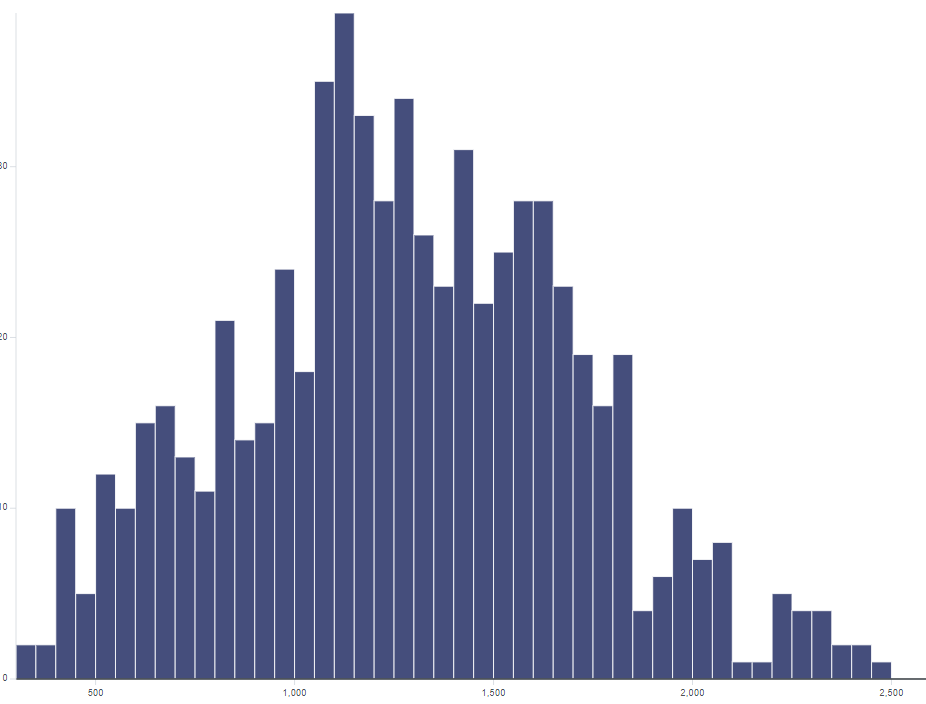
## liews by 15 min (it loks "normal")
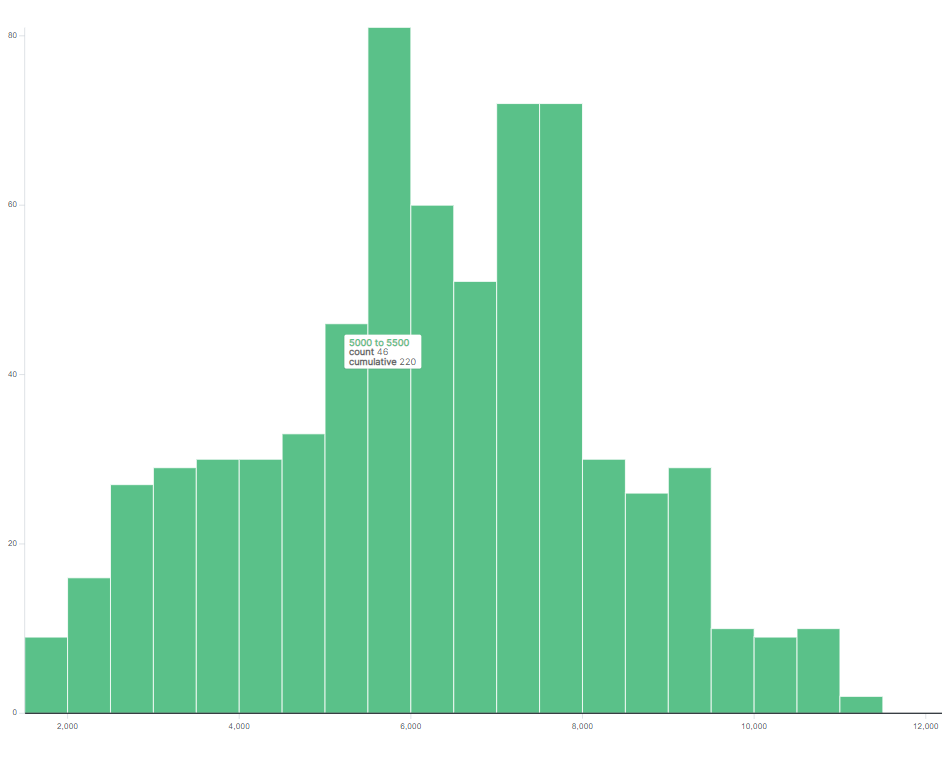
## active users - looks Uniform
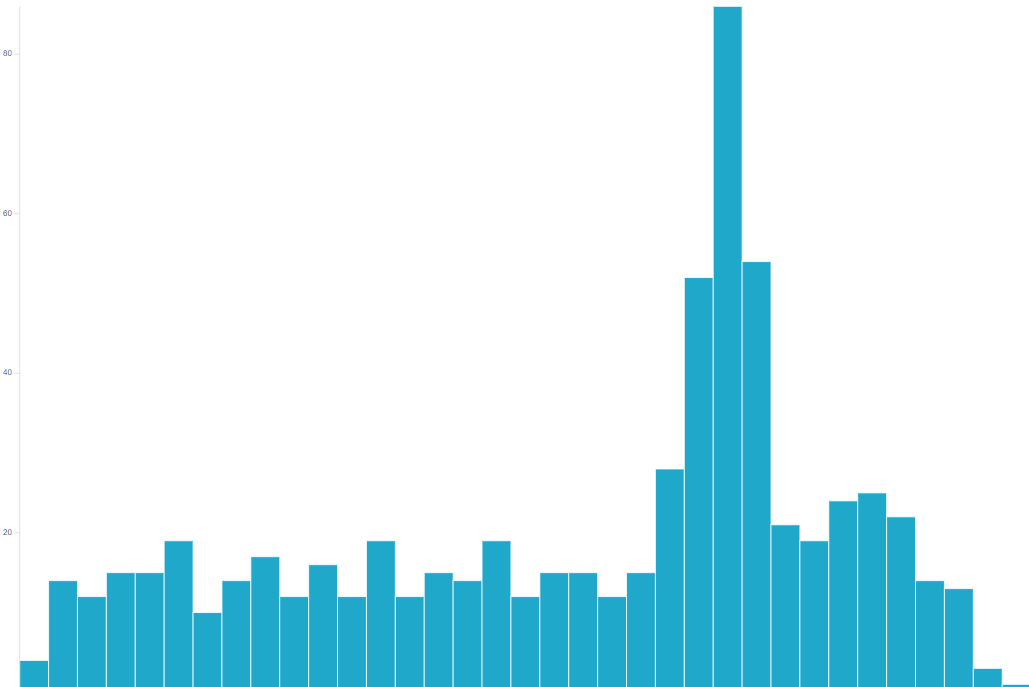
## ctr - looks normal
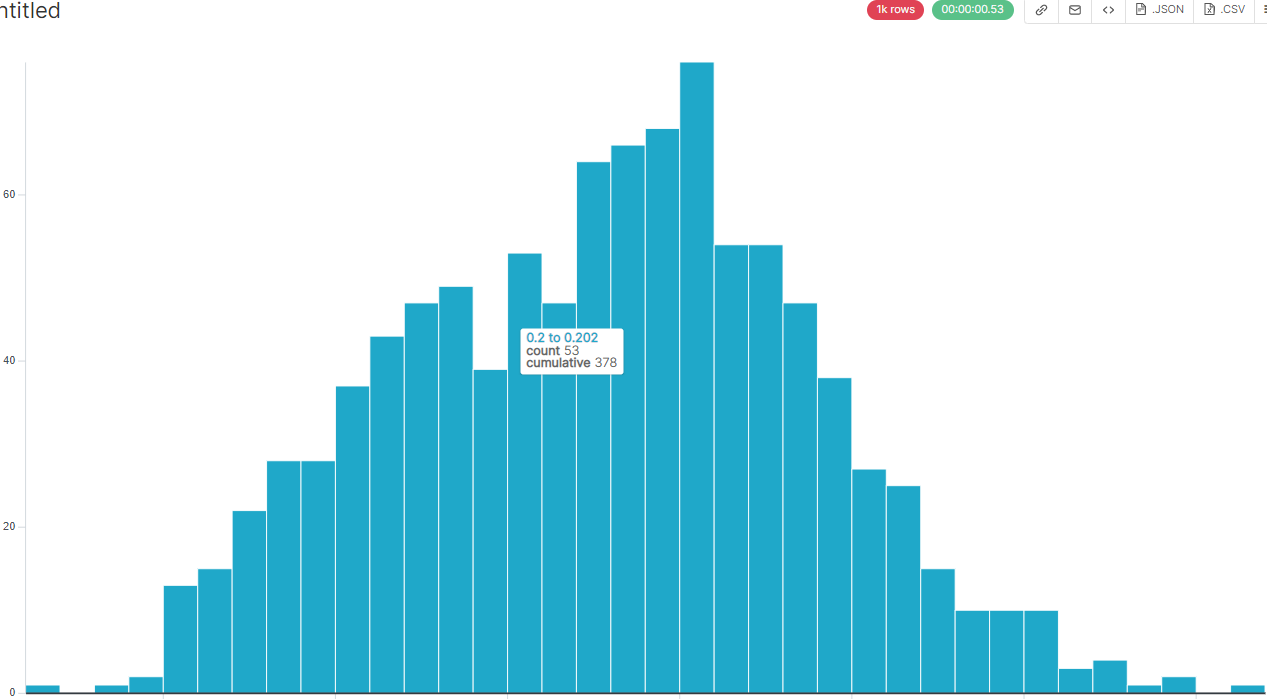

In [1]:
2+2

4